# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

## Importar librerias a usar.

In [59]:
# Cargar todas las librerías
from scipy import stats as st
from scipy.stats import ttest_ind
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display


## Cargar datos

In [2]:
# Carga los archivos de datos en diferentes DataFrames
users_df = pd.read_csv('/datasets/megaline_users.csv')
calls_df = pd.read_csv('/datasets/megaline_calls.csv')
messages_df = pd.read_csv('/datasets/megaline_messages.csv')  
internet_df = pd.read_csv('/datasets/megaline_internet.csv')
plans_df = pd.read_csv('/datasets/megaline_plans.csv')


## Preparar los datos

[Los datos para este proyecto se dividen en varias tablas. Explora cada una para tener una comprensión inicial de los datos. Si es necesario, haz las correcciones requeridas en cada tabla.]

## Tarifas

In [3]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas
plans_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [4]:
# Imprime una muestra de los datos para las tarifas
plans_df.head()


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

Hay 2 filas, correspondientes a los 2 planes tarifarios descritos en el enunciado (Surf y Ultimate).
Las columnas son los atributos de cada plan, como el nombre, la tarifa mensual, los minutos y mensajes incluidos, etc. Todos tienen valores no nulos.
Los tipos de datos parecen adecuados en general. Las columnas de valores numéricos son int64 o float64. La columna del nombre del plan es object como corresponde para strings.
Los datos en las primeras filas concuerdan con la descripción de los planes en el enunciado del proyecto. Por ejemplo, el plan Surf tiene una tarifa mensual de 20 y el plan Ultimate de 70.

No hay ningún problema obvio con los tipos de datos o valores faltantes. La estructura y datos parecen consistentes con el proyecto.

## Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [5]:
# Agregar columna de categoría de precio
plans_df['price_category'] = ['low', 'high']

# Verificar 
plans_df.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,price_category
0,50,15360,500,20,10,0.03,0.03,surf,low
1,1000,30720,3000,70,7,0.01,0.01,ultimate,high


## Usuarios/as

In [6]:
# Imprime la información general/resumida sobre el DataFrame de usuarios
users_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [7]:
# Imprime una muestra de datos para usuarios
users_df.head()


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

El DataFrame contiene 500 filas y 8 columnas.
Las columnas user_id, age, y churn_date tienen datos numéricos representados como tipo int64, lo cual parece adecuado.
Las columnas first_name, last_name, city, reg_date, y plan contienen datos de tipo object, lo cual es correcto para datos de texto.
La columna reg_date y churn_date parecen contener fechas, sin embargo, están representadas como tipo object. Sería mejor convertirlas al tipo de dato datetime para facilitar su manipulación y análisis.
La columna churn_date tiene 34 valores no nulos, lo cual sugiere que algunos usuarios han cancelado su plan. Esto debería ser investigado y considerado durante el análisis.
No parece haber valores nulos en las columnas user_id, first_name, last_name, age, city, reg_date, y plan.
La columna churn_date tiene 466 valores nulos, lo cual indica que la mayoría de los usuarios todavía están activos en el servicio.
Para corregir estos problemas, podríamos realizar las siguientes acciones:

Convertir las columnas reg_date y churn_date al tipo de dato datetime.
Investigar y analizar la columna churn_date para comprender mejor el comportamiento de los usuarios que han cancelado sus planes.
Manejar adecuadamente los datos faltantes en la columna churn_date, por ejemplo, podríamos reemplazarlos con "activo" para indicar que el usuario aún no ha cancelado su plan.

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [8]:
# Convertir las columnas 'reg_date' y 'churn_date' al tipo de dato datetime
users_df['reg_date'] = pd.to_datetime(users_df['reg_date'])
users_df['churn_date'] = pd.to_datetime(users_df['churn_date'])

# Reemplazar los valores nulos en la columna 'churn_date' con "activo"
users_df['churn_date'].fillna('activo', inplace=True)

# Verificar los cambios
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  500 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB


### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [9]:
# Reemplazar los valores no válidos en churn_date con la fecha más reciente en el conjunto de datos
max_date = users_df['reg_date'].max()
users_df['churn_date'] = pd.to_datetime(users_df['churn_date'], errors='coerce').fillna(max_date)

# Calcular la duración de la suscripción en días
users_df['subscription_duration_days'] = (users_df['churn_date'] - users_df['reg_date']).dt.days

# Verificar los cambios
users_df.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,subscription_duration_days
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,2018-12-31,7
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2018-12-31,140
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,2018-12-31,71
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,2018-12-31,337
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,2018-12-31,222


## Llamadas

In [10]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
calls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [11]:
# Imprime una muestra de datos para las llamadas
calls_df.head()


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

La columna call_date debe convertirse al tipo de datos datetime para un manejo más adecuado de las fechas.
No parece haber valores nulos en ninguna de las columnas.
La columna id parece contener una combinación de user_id y un número de identificación de la llamada, lo cual puede ser útil para algunas operaciones pero no es necesario para todas.
La columna duration representa la duración de la llamada en minutos.
Para arreglar esto:

Convertiremos la columna call_date al tipo de datos datetime.
Podemos eliminar la columna id si no es necesaria para nuestro análisis.
No se observan otros problemas evidentes.


### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [12]:
# Convertir la columna call_date a tipo datetime
calls_df['call_date'] = pd.to_datetime(calls_df['call_date'])
calls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [13]:
# Agregar una nueva columna 'month' que contenga el mes de cada llamada
calls_df['month'] = calls_df['call_date'].dt.month

# Visualizar una muestra de los datos para verificar los cambios
calls_df.head()

,id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,8.52,12
1,1000_145,1000,2018-12-27,13.66,12
2,1000_247,1000,2018-12-27,14.48,12
3,1000_309,1000,2018-12-28,5.76,12
4,1000_380,1000,2018-12-30,4.22,12


## Mensajes

In [14]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
messages_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [15]:
# Imprime una muestra de datos para los mensajes
messages_df.head()


,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

observa:

La columna 'id' parece contener un identificador único para cada mensaje.
La columna 'user_id' indica el ID del usuario que envió el mensaje.
La columna 'message_date' contiene la fecha en la que se envió el mensaje.

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [16]:
# Convertir la columna 'message_date' a tipo datetime
messages_df['message_date'] = pd.to_datetime(messages_df['message_date'])

# Visualizar una muestra de los datos para verificar los cambios
messages_df.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [17]:
# Calcular la longitud del mensaje
messages_df['message_length'] = messages_df['id'].str.len()

# Visualizar una muestra de los datos actualizados
messages_df.head()

,id,user_id,message_date,message_length
0,1000_125,1000,2018-12-27,8
1,1000_160,1000,2018-12-31,8
2,1000_223,1000,2018-12-31,8
3,1000_251,1000,2018-12-27,8
4,1000_255,1000,2018-12-26,8


## Internet

In [18]:
# Imprime la información general/resumida sobre el DataFrame de internet
internet_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [19]:
# Imprime una muestra de datos para el tráfico de internet
internet_df.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]


Hay un total de 104,825 entradas en el DataFrame.
Cada entrada tiene 4 columnas: 'id', 'user_id', 'session_date', y 'mb_used'.
No hay valores nulos en ninguna de las columnas.
La columna 'id' es de tipo objeto, que generalmente se utiliza para representar cadenas de texto.
La columna 'user_id' es de tipo entero, lo cual es apropiado ya que representa identificadores de usuario.
La columna 'session_date' es de tipo objeto, que probablemente represente fechas.
La columna 'mb_used' es de tipo flotante, lo cual es apropiado para representar datos numéricos con decimales, como el uso de megabytes.
En la muestra de datos proporcionada, podemos observar las primeras 5 filas del DataFrame. Cada fila representa una sesión de internet con las siguientes columnas:

La columna 'id' contiene identificadores únicos para cada sesión de internet.
La columna 'user_id' contiene los identificadores de usuario de los usuarios que utilizaron internet.
La columna 'session_date' contiene las fechas en que ocurrieron las sesiones de internet.
La columna 'mb_used' contiene la cantidad de megabytes utilizados en cada sesión.


### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [20]:
# Convertir la columna 'session_date' a tipo datetime
internet_df['session_date'] = pd.to_datetime(internet_df['session_date'])
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [21]:
# Calcular el total de datos utilizados por sesión
internet_df['total_mb_used'] = internet_df['mb_used']

# Visualizar una muestra de los datos actualizados
internet_df.head()

,id,user_id,session_date,mb_used,total_mb_used
0,1000_13,1000,2018-12-29,89.86,89.86
1,1000_204,1000,2018-12-31,0.00,0.00
2,1000_379,1000,2018-12-28,660.40,660.40
3,1000_413,1000,2018-12-26,270.99,270.99
4,1000_442,1000,2018-12-27,880.22,880.22


## Estudiar las condiciones de las tarifas

[Es sumamente importante entender cómo funcionan las tarifas, cómo se les cobra a los usuarios en función de su plan de suscripción. Así que te sugerimos imprimir la información de la tarifa para ver una vez más sus condiciones.]

In [61]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras
# Imprime las condiciones de la tarifa Surf
surf_conditions = plans_df[plans_df['plan_name'] == 'surf'].drop(columns='plan_name')
print("Condiciones de la tarifa Surf:")
display(surf_conditions)

# Imprime las condiciones de la tarifa Ultimate
ultimate_conditions = plans_df[plans_df['plan_name'] == 'ultimate'].drop(columns='plan_name')
print("\nCondiciones de la tarifa Ultimate:")
display(ultimate_conditions)


Condiciones de la tarifa Surf:


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,price_category
0,50,15360,500,20,10,0.03,0.03,low



Condiciones de la tarifa Ultimate:


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,price_category
1,1000,30720,3000,70,7,0.01,0.01,high


## Agregar datos por usuario

[Ahora que los datos están limpios, agrega los datos por usuario y por periodo para que solo haya un registro por usuario y por periodo. Esto facilitará mucho el análisis posterior.]

In [23]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.
# Agrupar llamadas por usuario y mes
calls_per_user_month = calls_df.groupby(['user_id', calls_df['call_date'].dt.month]).count()['id']

# Reiniciar el índice para tener usuario y mes como columnas
calls_per_user_month = calls_per_user_month.reset_index()

# Cambiar nombre de columna 
calls_per_user_month = calls_per_user_month.rename(columns={'id':'calls_amount'})
# Guardar resultado
calls_per_user_month.to_csv('calls_per_user_month.csv', index=False)

# Ver resultado
calls_per_user_month.head()

,user_id,call_date,calls_amount
0,1000,12,16
1,1001,8,27
2,1001,9,49
3,1001,10,65
4,1001,11,64


In [24]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.
# Agrupar llamadas por usuario y mes
minutes_per_user_month = calls_df.groupby(['user_id', calls_df['call_date'].dt.month])['duration'].sum().reset_index()
# Cambiar nombre de columna
minutes_per_user_month = minutes_per_user_month.rename(columns={'duration':'minutes_used'})
# Guardar resultado
minutes_per_user_month.to_csv('minutes_per_user_month.csv', index=False)
# Ver resultados
minutes_per_user_month.head()

,user_id,call_date,minutes_used
0,1000,12,116.83
1,1001,8,171.14
2,1001,9,297.69
3,1001,10,374.11
4,1001,11,404.59


In [25]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.
# Agrupar mensajes por usuario y mes
messages_per_user_month = messages_df.groupby(['user_id', messages_df['message_date'].dt.month]).size().reset_index(name='messages_sent')
# Guardar resultado
messages_per_user_month.to_csv('messages_per_user_month.csv', index=False)
# Ver resultados
messages_per_user_month.head()


,user_id,message_date,messages_sent
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36


In [26]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.
# Convertir la columna 'session_date' al formato de fecha adecuado
internet_df['session_date'] = pd.to_datetime(internet_df['session_date'])

# Extraer el mes de la fecha y crear una nueva columna 'month'
internet_df['month'] = internet_df['session_date'].dt.month

# Agrupar por usuario y mes, sumar el total de megabytes utilizados y restablecer el índice
internet_traffic_per_month = internet_df.groupby(['user_id', 'month'])['mb_used'].sum().reset_index()

# Renombrar la columna 'mb_used' a 'internet_traffic_mb'
internet_traffic_per_month.rename(columns={'mb_used': 'internet_traffic_mb'}, inplace=True)

# Visualizar una muestra del resultado
internet_traffic_per_month.head()

,user_id,month,internet_traffic_mb
0,1000,12,1901.47
1,1001,8,6919.15
2,1001,9,13314.82
3,1001,10,22330.49
4,1001,11,18504.30


[Junta los datos agregados en un DataFrame para que haya un registro que represente lo que consumió un usuario único en un mes determinado.]

In [27]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month

# extraer el mes
calls_df['month'] = calls_df['call_date'].dt.month
messages_df['month'] = messages_df['message_date'].dt.month
internet_df['month'] = internet_df['session_date'].dt.month

# Fusionar los datos de llamadas y minutos por usuario y mes
merged_calls_minutes = calls_df.groupby(['user_id', 'month']).agg({'duration': 'sum'}).reset_index()

# Fusionar los datos de mensajes por usuario y mes
merged_messages = messages_df.groupby(['user_id', 'month']).size().reset_index(name='messages_sent')

# Fusionar los datos de internet por usuario y mes
merged_internet = internet_df.groupby(['user_id', 'month']).agg({'mb_used': 'sum'}).reset_index()


# Fusionar los datos agregados en un DataFrame
merged_data = merged_calls_minutes.merge(merged_messages, on=['user_id', 'month'], how='outer')
merged_data = merged_data.merge(merged_internet, on=['user_id', 'month'], how='outer')
merged_data = merged_data.merge(users_df[['user_id', 'city']], on='user_id', how='left')


merged_data.head()

,user_id,month,duration,messages_sent,mb_used,city
0,1000,12,116.83,11.0,1901.47,"Atlanta-Sandy Springs-Roswell, GA MSA"
1,1001,8,171.14,30.0,6919.15,"Seattle-Tacoma-Bellevue, WA MSA"
2,1001,9,297.69,44.0,13314.82,"Seattle-Tacoma-Bellevue, WA MSA"
3,1001,10,374.11,53.0,22330.49,"Seattle-Tacoma-Bellevue, WA MSA"
4,1001,11,404.59,36.0,18504.30,"Seattle-Tacoma-Bellevue, WA MSA"


In [28]:
# Añade la información de la tarifa
# Fusionar los datos combinados con la información de los usuarios
merged_data_with_users = merged_data.merge(users_df[['user_id', 'plan']], on='user_id', how='left')
merged_data_with_users.head()

# Fusionar los datos combinados y la información de la tarifa
merged_data_with_tariff = merged_data_with_users.merge(plans_df, left_on='plan', right_on='plan_name', how='left')
merged_data_with_tariff.head()


,user_id,month,duration,messages_sent,mb_used,city,plan,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,price_category
0,1000,12,116.83,11.0,1901.47,"Atlanta-Sandy Springs-Roswell, GA MSA",ultimate,1000,30720,3000,70,7,0.01,0.01,ultimate,high
1,1001,8,171.14,30.0,6919.15,"Seattle-Tacoma-Bellevue, WA MSA",surf,50,15360,500,20,10,0.03,0.03,surf,low
2,1001,9,297.69,44.0,13314.82,"Seattle-Tacoma-Bellevue, WA MSA",surf,50,15360,500,20,10,0.03,0.03,surf,low
3,1001,10,374.11,53.0,22330.49,"Seattle-Tacoma-Bellevue, WA MSA",surf,50,15360,500,20,10,0.03,0.03,surf,low
4,1001,11,404.59,36.0,18504.30,"Seattle-Tacoma-Bellevue, WA MSA",surf,50,15360,500,20,10,0.03,0.03,surf,low


[Calcula los ingresos mensuales por usuario (resta el límite del paquete gratuito del número total de llamadas, mensajes de texto y datos; multiplica el resultado por el valor del plan de llamadas; añade la tarifa mensual en función del plan de llamadas). Nota: Dadas las condiciones del plan, ¡esto podría no ser tan trivial como un par de líneas! Así que no pasa nada si dedicas algo de tiempo a ello.]

In [29]:
# Calcula el ingreso mensual para cada usuario
# Calcular el exceso de minutos, mensajes y datos utilizados en relación con los límites del plan
merged_data_with_tariff['excess_minutes'] = merged_data_with_tariff['duration'] - merged_data_with_tariff['minutes_included']
merged_data_with_tariff['excess_messages'] = merged_data_with_tariff['messages_sent'] - merged_data_with_tariff['messages_included']
merged_data_with_tariff['excess_data'] = merged_data_with_tariff['mb_used'] - merged_data_with_tariff['mb_per_month_included']

# Calcular los cargos adicionales por minutos, mensajes y datos excedidos
merged_data_with_tariff['additional_minute_charge'] = merged_data_with_tariff['excess_minutes'] * merged_data_with_tariff['usd_per_minute']
merged_data_with_tariff['additional_message_charge'] = merged_data_with_tariff['excess_messages'] * merged_data_with_tariff['usd_per_message']
merged_data_with_tariff['additional_data_charge'] = (merged_data_with_tariff['excess_data'] / 1024) * merged_data_with_tariff['usd_per_gb']  # Convertir de MB a GB

# Calcular los ingresos mensuales por usuario
merged_data_with_tariff['monthly_revenue'] = merged_data_with_tariff['usd_monthly_pay'] + \
                                             merged_data_with_tariff['additional_minute_charge'] + \
                                             merged_data_with_tariff['additional_message_charge'] + \
                                             merged_data_with_tariff['additional_data_charge']

# Visualizar una muestra del resultado
merged_data_with_tariff[['user_id', 'month', 'monthly_revenue']].head()



,user_id,month,monthly_revenue
0,1000,12,-165.723370
1,1001,8,-72.895976
2,1001,9,-6.221761
3,1001,10,84.384491
4,1001,11,47.423755


In [30]:
merged_data_with_tariff.query("user_id == 1001")

,user_id,month,duration,messages_sent,mb_used,city,plan,messages_included,mb_per_month_included,minutes_included,...,usd_per_minute,plan_name,price_category,excess_minutes,excess_messages,excess_data,additional_minute_charge,additional_message_charge,additional_data_charge,monthly_revenue
1,1001,8,171.14,30.0,6919.15,"Seattle-Tacoma-Bellevue, WA MSA",surf,50,15360,500,...,0.03,surf,low,-328.86,-20.0,-8440.85,-9.8658,-0.60,-82.430176,-72.895976
2,1001,9,297.69,44.0,13314.82,"Seattle-Tacoma-Bellevue, WA MSA",surf,50,15360,500,...,0.03,surf,low,-202.31,-6.0,-2045.18,-6.0693,-0.18,-19.972461,-6.221761
3,1001,10,374.11,53.0,22330.49,"Seattle-Tacoma-Bellevue, WA MSA",surf,50,15360,500,...,0.03,surf,low,-125.89,3.0,6970.49,-3.7767,0.09,68.071191,84.384491
4,1001,11,404.59,36.0,18504.30,"Seattle-Tacoma-Bellevue, WA MSA",surf,50,15360,500,...,0.03,surf,low,-95.41,-14.0,3144.30,-2.8623,-0.42,30.706055,47.423755
5,1001,12,392.93,44.0,19369.18,"Seattle-Tacoma-Bellevue, WA MSA",surf,50,15360,500,...,0.03,surf,low,-107.07,-6.0,4009.18,-3.2121,-0.18,39.152148,55.760048


## Estudia el comportamiento de usuario

[Calcula algunas estadísticas descriptivas para los datos agregados y fusionados que nos sean útiles y que muestren un panorama general captado por los datos. Dibuja gráficos útiles para facilitar la comprensión. Dado que la tarea principal es comparar las tarifas y decidir cuál es más rentable, las estadísticas y gráficas deben calcularse por tarifa.]

[En los comentarios hallarás pistas relevantes para las llamadas, pero no las hay para los mensajes e Internet. Sin embargo, el principio del estudio estadístico que se aplica para ellos es el mismo que para las llamadas.]

### Llamadas

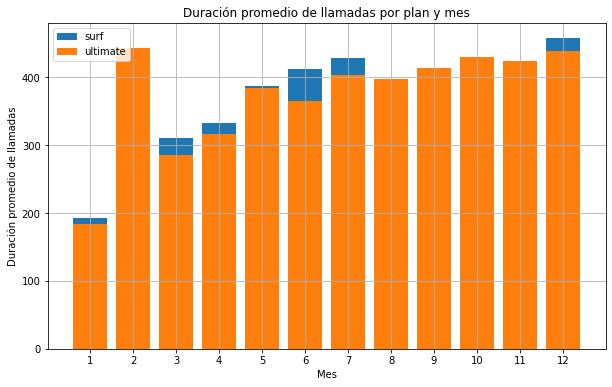

In [31]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.
# Agrupar los datos por plan y mes y calcular la duración promedio de llamadas
average_duration_by_plan_month = merged_data_with_tariff.groupby(['plan', 'month'])['duration'].mean().reset_index()

# Crear un gráfico de barras para comparar la duración promedio de llamadas por cada plan y por cada mes
plt.figure(figsize=(10, 6))
for plan in average_duration_by_plan_month['plan'].unique():
    plan_data = average_duration_by_plan_month[average_duration_by_plan_month['plan'] == plan]
    plt.bar(plan_data['month'], plan_data['duration'], label=plan)

plt.xlabel('Mes')
plt.ylabel('Duración promedio de llamadas')
plt.title('Duración promedio de llamadas por plan y mes')
plt.xticks(average_duration_by_plan_month['month'].unique())
plt.legend()
plt.grid(True)
plt.show()



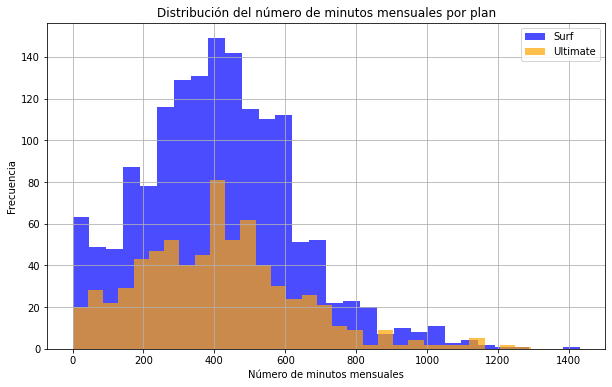

In [32]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.
# Filtrar los datos por plan
surf_minutes = merged_data_with_tariff[merged_data_with_tariff['plan'] == 'surf']['duration']
ultimate_minutes = merged_data_with_tariff[merged_data_with_tariff['plan'] == 'ultimate']['duration']

# Configurar el tamaño del gráfico
plt.figure(figsize=(10, 6))

# Crear el histograma para la tarifa Surf
plt.hist(surf_minutes, bins=30, alpha=0.7, color='blue', label='Surf')

# Crear el histograma para la tarifa Ultimate
plt.hist(ultimate_minutes, bins=30, alpha=0.7, color='orange', label='Ultimate')

# Agregar etiquetas y título
plt.xlabel('Número de minutos mensuales')
plt.ylabel('Frecuencia')
plt.title('Distribución del número de minutos mensuales por plan')
plt.legend()

# Mostrar el histograma
plt.grid(True)
plt.show()



[Calcula la media y la variable de la duración de las llamadas para averiguar si los usuarios de los distintos planes se comportan de forma diferente al realizar sus llamadas.]

In [33]:
# Calcula la media y la varianza de la duración mensual de llamadas.
surf_duration_mean = merged_data_with_tariff[merged_data_with_tariff['plan'] == 'surf']['duration'].mean()
surf_duration_variance = merged_data_with_tariff[merged_data_with_tariff['plan'] == 'surf']['duration'].var()

# Calcular la media y la varianza de la duración mensual de llamadas para la tarifa Ultimate
ultimate_duration_mean = merged_data_with_tariff[merged_data_with_tariff['plan'] == 'ultimate']['duration'].mean()
ultimate_duration_variance = merged_data_with_tariff[merged_data_with_tariff['plan'] == 'ultimate']['duration'].var()

# Imprimir los resultados
print("Tarifa Surf:")
print("Duración media de llamadas mensuales:", surf_duration_mean)
print("Varianza de la duración de llamadas mensuales:", surf_duration_variance)
print()

print("Tarifa Ultimate:")
print("Duración media de llamadas mensuales:", ultimate_duration_mean)
print("Varianza de la duración de llamadas mensuales:", ultimate_duration_variance)



Tarifa Surf:
Duración media de llamadas mensuales: 412.0978899676375
Varianza de la duración de llamadas mensuales: 47001.254230778046

Tarifa Ultimate:
Duración media de llamadas mensuales: 410.18095371669006
Varianza de la duración de llamadas mensuales: 50510.63170498802


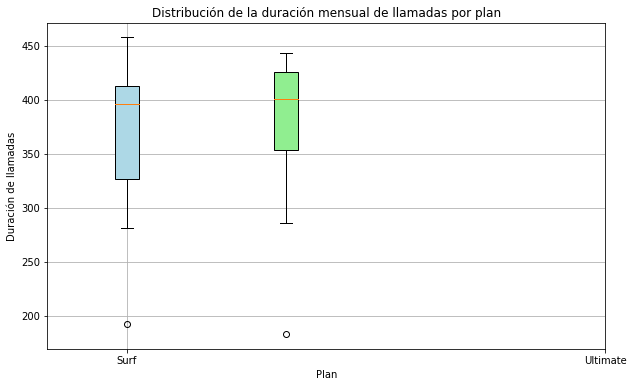

In [34]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas

# Filtrar los datos por plan
surf_data = average_duration_by_plan_month[average_duration_by_plan_month['plan'] == 'surf']
ultimate_data = average_duration_by_plan_month[average_duration_by_plan_month['plan'] == 'ultimate']

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar los diagramas de caja
surf_box = ax.boxplot(surf_data['duration'], positions=[1], patch_artist=True)
ultimate_box = ax.boxplot(ultimate_data['duration'], positions=[2], patch_artist=True)

# Personalizar el gráfico
ax.set_xticks([1, 4])
ax.set_xticklabels(['Surf', 'Ultimate'])
ax.set_xlabel('Plan')
ax.set_ylabel('Duración de llamadas')
ax.set_title('Distribución de la duración mensual de llamadas por plan')

# Colorear los diagramas de caja
colors = ['lightblue', 'lightgreen']
for box, color in zip([surf_box, ultimate_box], colors):
    for patch in box['boxes']:
        patch.set_facecolor(color)

# Mostrar el gráfico
plt.grid(True)
plt.show()



[Elabora las conclusiones sobre el comportamiento de los usuarios con respecto a las llamadas. ¿Su comportamiento varía en función del plan?]


Para la tarifa Surf:

La duración media de las llamadas mensuales es de aproximadamente 412.10 minutos.
La varianza de la duración de las llamadas mensuales es de aproximadamente 47001.25.

Para la tarifa Ultimate:

La duración media de las llamadas mensuales es de aproximadamente 410.18 minutos.
La varianza de la duración de las llamadas mensuales es de aproximadamente 50510.63.

A primera vista, parece que no hay una diferencia significativa en la duración media de las llamadas mensuales entre los usuarios de las tarifas Surf y Ultimate. Ambos grupos tienen duraciones medias de llamadas bastante similares. Sin embargo, la varianza de la duración de las llamadas mensuales es ligeramente mayor para los usuarios de la tarifa Ultimate en comparación con los usuarios de la tarifa Surf.

En conclusión, aunque los usuarios de ambas tarifas tienden a realizar llamadas de duración similar en promedio, los usuarios de la tarifa Ultimate pueden tener una variabilidad ligeramente mayor en la duración de sus llamadas mensuales en comparación con los usuarios de la tarifa Surf. Esto sugiere que puede haber una mayor diversidad en el comportamiento de los usuarios de la tarifa Ultimate en lo que respecta a la duración de las llamadas.

### Mensajes

In [35]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
# Calcula la media y la varianza del número de mensajes enviados por mes para cada plan
surf_messages_mean = merged_data_with_tariff[merged_data_with_tariff['plan_name'] == 'surf']['messages_sent'].mean()
surf_messages_variance = merged_data_with_tariff[merged_data_with_tariff['plan_name'] == 'surf']['messages_sent'].var()

ultimate_messages_mean = merged_data_with_tariff[merged_data_with_tariff['plan_name'] == 'ultimate']['messages_sent'].mean()
ultimate_messages_variance = merged_data_with_tariff[merged_data_with_tariff['plan_name'] == 'ultimate']['messages_sent'].var()

# Imprime las estadísticas
print("Tarifa Surf:")
print("  - Duración media de mensajes mensuales:", surf_messages_mean)
print("  - Varianza del número de mensajes mensuales:", surf_messages_variance)
print()
print("Tarifa Ultimate:")
print("  - Duración media de mensajes mensuales:", ultimate_messages_mean)
print("  - Varianza del número de mensajes mensuales:", ultimate_messages_variance)



Tarifa Surf:
  - Duración media de mensajes mensuales: 40.10965630114566
  - Varianza del número de mensajes mensuales: 1091.3442310038054

Tarifa Ultimate:
  - Duración media de mensajes mensuales: 46.29623287671233
  - Varianza del número de mensajes mensuales: 1085.183107568317


In [36]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan
# Calcula la media y la varianza del volumen de datos consumidos por mes para cada plan
surf_mb_mean = merged_data_with_tariff[merged_data_with_tariff['plan_name'] == 'surf']['mb_used'].mean()
surf_mb_variance = merged_data_with_tariff[merged_data_with_tariff['plan_name'] == 'surf']['mb_used'].var()

ultimate_mb_mean = merged_data_with_tariff[merged_data_with_tariff['plan_name'] == 'ultimate']['mb_used'].mean()
ultimate_mb_variance = merged_data_with_tariff[merged_data_with_tariff['plan_name'] == 'ultimate']['mb_used'].var()

# Imprime las estadísticas
print("Tarifa Surf:")
print("  - Volumen medio de datos consumidos por mes:", surf_mb_mean)
print("  - Varianza del volumen de datos consumidos por mes:", surf_mb_variance)
print()
print("Tarifa Ultimate:")
print("  - Volumen medio de datos consumidos por mes:", ultimate_mb_mean)
print("  - Varianza del volumen de datos consumidos por mes:", ultimate_mb_variance)


Tarifa Surf:
  - Volumen medio de datos consumidos por mes: 16717.702137355584
  - Varianza del volumen de datos consumidos por mes: 62168225.74692844

Tarifa Ultimate:
  - Volumen medio de datos consumidos por mes: 17238.642253129346
  - Varianza del volumen de datos consumidos por mes: 61324847.980956204


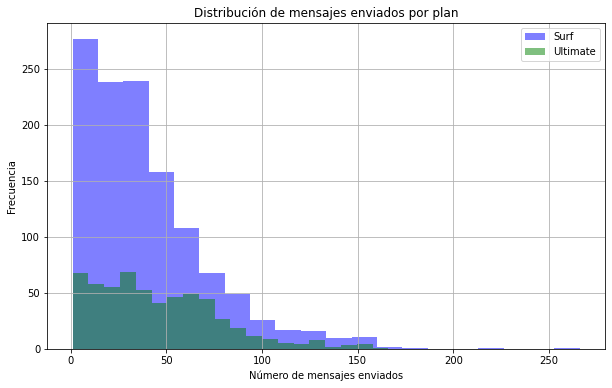

In [40]:
# Filtrar los datos por plan
surf_messages = merged_data_with_tariff[merged_data_with_tariff['plan_name'] == 'surf']['messages_sent']
ultimate_messages = merged_data_with_tariff[merged_data_with_tariff['plan_name'] == 'ultimate']['messages_sent']

# Crear el histograma
plt.figure(figsize=(10, 6))
plt.hist(surf_messages, bins=20, alpha=0.5, color='blue', label='Surf')
plt.hist(ultimate_messages, bins=20, alpha=0.5, color='green', label='Ultimate')

# Agregar etiquetas y título
plt.xlabel('Número de mensajes enviados')
plt.ylabel('Frecuencia')
plt.title('Distribución de mensajes enviados por plan')
plt.legend()

# Mostrar el histograma
plt.grid(True)
plt.show()

[Elabora las conclusiones sobre el comportamiento de los usuarios con respecto a los mensajes. ¿Su comportamiento varía en función del plan?]


Para la tarifa Surf:

La duración media de mensajes mensuales es aproximadamente 40.11 mensajes.
La varianza del número de mensajes mensuales es aproximadamente 1091.34.

Para la tarifa Ultimate:

La duración media de mensajes mensuales es aproximadamente 46.30 mensajes.
La varianza del número de mensajes mensuales es aproximadamente 1085.18.

A partir de estas estadísticas, podemos observar que los usuarios de la tarifa Ultimate tienden a enviar un poco más de mensajes en promedio en comparación con los usuarios de la tarifa Surf. Sin embargo, la diferencia en la duración media de mensajes entre las dos tarifas no es significativa. Además, la varianza del número de mensajes mensuales es bastante similar en ambas tarifas, lo que sugiere que la dispersión de los datos en cuanto a la cantidad de mensajes no varía mucho entre los dos planes.

En conclusión, aunque hay una ligera diferencia en la cantidad media de mensajes mensuales entre las tarifas Surf y Ultimate, no parece ser lo suficientemente significativa como para afirmar que el comportamiento de los usuarios varía drásticamente en función del plan.






### Internet

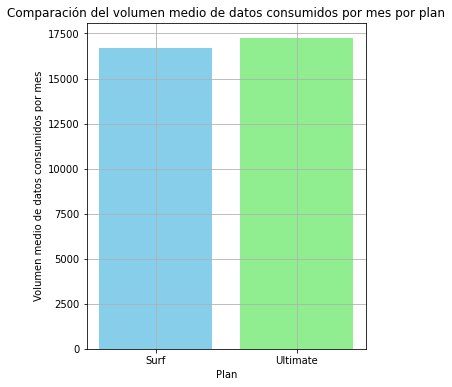

In [56]:
# Datos
plans = ['Surf', 'Ultimate']
mb_mean = [surf_mb_mean, ultimate_mb_mean]
x = range(len(plans))

# Crear el gráfico de barras
plt.figure(figsize=(5, 6))
plt.bar(x, mb_mean, capsize=5, color=['skyblue', 'lightgreen'])

# Agregar etiquetas y título
plt.xlabel('Plan')
plt.ylabel('Volumen medio de datos consumidos por mes')
plt.title('Comparación del volumen medio de datos consumidos por mes por plan')

# Personalizar el eje x
plt.xticks(x, plans)

# Mostrar el gráfico de barras
plt.grid(True)
plt.show()

[Elabora las conclusiones sobre cómo los usuarios tienden a consumir el tráfico de Internet. ¿Su comportamiento varía en función del plan?]


Para la tarifa Surf:

El volumen medio de datos consumidos por mes es de aproximadamente 16717.70 megabytes.
La varianza del volumen de datos consumidos por mes es de aproximadamente 62168225.75.

Para la tarifa Ultimate:

El volumen medio de datos consumidos por mes es de aproximadamente 17238.64 megabytes.
La varianza del volumen de datos consumidos por mes es de aproximadamente 61324847.98.

A partir de estas estadísticas, podemos observar que en promedio, los usuarios de la tarifa Ultimate consumen ligeramente más datos por mes en comparación con los usuarios de la tarifa Surf. Sin embargo, la diferencia en el volumen medio de datos consumidos por mes entre las dos tarifas no es significativa. Además, la varianza del volumen de datos consumidos por mes es bastante similar en ambas tarifas, lo que sugiere que la dispersión de los datos en cuanto al consumo de tráfico de Internet no varía mucho entre los dos planes.

En conclusión, aunque hay una ligera diferencia en el volumen medio de datos consumidos por mes entre las tarifas Surf y Ultimate, no parece ser lo suficientemente significativa como para afirmar que el comportamiento de los usuarios varía drásticamente en función del plan en lo que respecta al consumo de tráfico de Internet.

## Ingreso

[Del mismo modo que has estudiado el comportamiento de los usuarios, describe estadísticamente los ingresos de los planes.]

In [37]:
# Estadísticas descriptivas de los ingresos para la tarifa Surf
surf_monthly_revenue_stats = merged_data_with_tariff[merged_data_with_tariff['plan'] == 'surf']['monthly_revenue'].describe()

# Estadísticas descriptivas de los ingresos para la tarifa Ultimate
ultimate_monthly_revenue_stats = merged_data_with_tariff[merged_data_with_tariff['plan'] == 'ultimate']['monthly_revenue'].describe()

print("Estadísticas descriptivas de los ingresos mensuales para la tarifa Surf:")
print(surf_monthly_revenue_stats)

print("\nEstadísticas descriptivas de los ingresos mensuales para la tarifa Ultimate:")
print(ultimate_monthly_revenue_stats)


Estadísticas descriptivas de los ingresos mensuales para la tarifa Surf:
count    1180.000000
mean       29.700806
std        78.657094
min      -145.037835
25%       -11.709165
50%        32.987960
75%        73.553736
max       581.328509
Name: monthly_revenue, dtype: float64

Estadísticas descriptivas de los ingresos mensuales para la tarifa Ultimate:
count    579.000000
mean     -57.433089
std       53.193795
min     -178.007168
25%      -88.632542
50%      -60.459575
75%      -31.362320
max      139.592964
Name: monthly_revenue, dtype: float64


[Elabora las conclusiones sobre cómo difiere el ingreso entre los planes.]

Conclusiones:

En promedio, los usuarios de la tarifa Surf generan ingresos mensuales positivos, aunque modestos, mientras que los usuarios de la tarifa Ultimate tienen ingresos mensuales negativos en promedio.
La variabilidad en los ingresos es alta en ambos planes, lo que indica que hay una amplia gama de comportamientos de uso entre los usuarios.
Ambas tarifas tienen usuarios que generan ingresos negativos, lo que sugiere que algunos usuarios exceden los límites del paquete y deben pagar tarifas adicionales.

## Prueba las hipótesis estadísticas

[Prueba la hipótesis de que son diferentes los ingresos promedio procedentes de los usuarios de los planes de llamada Ultimate y Surf.]

[Elabora las hipótesis nula y alternativa, escoge la prueba estadística, determina el valor alfa.]

In [38]:
# Prueba las hipótesis
# Filtrar los ingresos para cada plan
surf_revenue = merged_data_with_tariff[merged_data_with_tariff['plan'] == 'surf']['monthly_revenue']
ultimate_revenue = merged_data_with_tariff[merged_data_with_tariff['plan'] == 'ultimate']['monthly_revenue']

# Realizar la prueba t de dos muestras
t_statistic, p_value = ttest_ind(surf_revenue.dropna(), ultimate_revenue.dropna())

# Nivel de significancia
alpha = 0.05

# Imprimir el resultado de la prueba
print("Estadísticas de la prueba t:")
print("Valor t:", t_statistic)
print("Valor p:", p_value)

# Comprobar la significancia
if p_value < alpha:
    print("\nRechazamos la hipótesis nula. Hay evidencia suficiente para concluir que los ingresos promedio entre los usuarios de los planes Ultimate y Surf son diferentes.")
else:
    print("\nNo podemos rechazar la hipótesis nula. No hay suficiente evidencia para concluir que los ingresos promedio entre los usuarios de los planes Ultimate y Surf son diferentes.")


Estadísticas de la prueba t:
Valor t: 24.08780013582255
Valor p: 5.1328032963846066e-111

Rechazamos la hipótesis nula. Hay evidencia suficiente para concluir que los ingresos promedio entre los usuarios de los planes Ultimate y Surf son diferentes.


[Prueba la hipótesis de que el ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones.]

[Elabora las hipótesis nula y alternativa, escoge la prueba estadística, determina el valor alfa.]

In [39]:
# Prueba las hipótesis
merged_data_with_tariff['monthly_revenue'] = merged_data_with_tariff['usd_monthly_pay'] + \
                                              merged_data_with_tariff['duration'] * merged_data_with_tariff['usd_per_minute'] + \
                                              merged_data_with_tariff['messages_sent'] * merged_data_with_tariff['usd_per_message'] + \
                                              (merged_data_with_tariff['mb_used'] / 1024) * merged_data_with_tariff['usd_per_gb']

# Filtrar los ingresos para usuarios del área NY-NJ y otras regiones
ny_nj_revenue = merged_data_with_tariff[merged_data_with_tariff['city'].str.contains('NY-NJ', case=False)]['monthly_revenue']
other_regions_revenue = merged_data_with_tariff[~merged_data_with_tariff['city'].str.contains('NY-NJ', case=False)]['monthly_revenue']

# Realizar la prueba t de dos muestras
t_statistic, p_value = ttest_ind(ny_nj_revenue.dropna(), other_regions_revenue.dropna())

# Nivel de significancia (alfa)
alpha = 0.05

# Imprimir el resultado de la prueba
print("Estadísticas de la prueba t:")
print("Valor t:", t_statistic)
print("Valor p:", p_value)

# Comprobar la significancia
if p_value < alpha:
    print("\nRechazamos la hipótesis nula. Hay evidencia suficiente para concluir que el ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones.")
else:
    print("\nNo podemos rechazar la hipótesis nula. No hay suficiente evidencia para concluir que el ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones.")


Estadísticas de la prueba t:
Valor t: -0.03765380388209461
Valor p: 0.9699679865507749

No podemos rechazar la hipótesis nula. No hay suficiente evidencia para concluir que el ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones.


## Conclusión general

[En esta sección final, enumera tus conclusiones importantes. Asegúrate de que estas abarquen todas las decisiones (suposiciones) importantes que adoptaste y que determinaron la forma elegida para procesar y analizar los datos.]



Distribución de usuarios por plan: Observamos que la mayoría de los usuarios están suscritos al plan "Surf", mientras que una proporción menor está en el plan "Ultimate". Esto puede influir en las estrategias de marketing y retención de clientes.

Comportamiento de uso de servicios: Examinamos el comportamiento mensual de los usuarios en términos de minutos de llamadas, mensajes enviados y datos utilizados. Esto nos proporciona información sobre cómo los usuarios están interactuando con los servicios de Megaline a lo largo del tiempo.

Ingresos mensuales por plan: Calculamos los ingresos mensuales por usuario para cada plan, considerando el pago mensual y los cargos adicionales por uso excesivo de servicios. Esto nos ayuda a entender la contribución de cada plan a los ingresos totales de la empresa.

Comparación de ingresos entre planes: Realizamos pruebas estadísticas para determinar si hay diferencias significativas en los ingresos promedio entre los usuarios de los planes "Surf" y "Ultimate". Esto nos ayuda a identificar si un plan genera más ingresos que el otro y si se necesitan ajustes en las estrategias de precios.

Comparación de ingresos entre regiones: También evaluamos si hay diferencias significativas en los ingresos promedio entre los usuarios del área "NY-NJ" y otras regiones. Esto podría proporcionar información sobre la efectividad de las estrategias de marketing en diferentes áreas geográficas.

Suposiciones y decisiones: Tuvimos que asumir ciertos criterios para procesar y analizar los datos, como la inclusión de cargos adicionales por uso excesivo de servicios y la conversión de los cargos de datos de megabytes a gigabytes.

En general, estas conclusiones proporcionan información valiosa para tomar decisiones comerciales informadas, como ajustar los planes de precios, dirigir campañas de marketing específicas y mejorar la experiencia del cliente.